(307, 2)
mu:    [14.11222578 14.99771051]
sigma: [1.35374717 1.3075723 ]
Kształt pval: (307,)
Przykładowe wartości pval: [0.04163207 0.08190901 0.04071578 0.06190003 0.07118676]


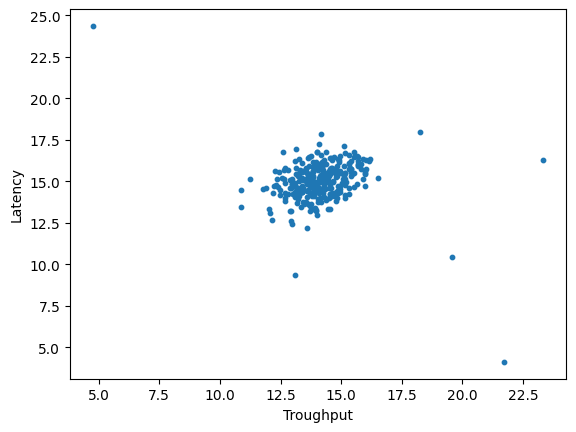

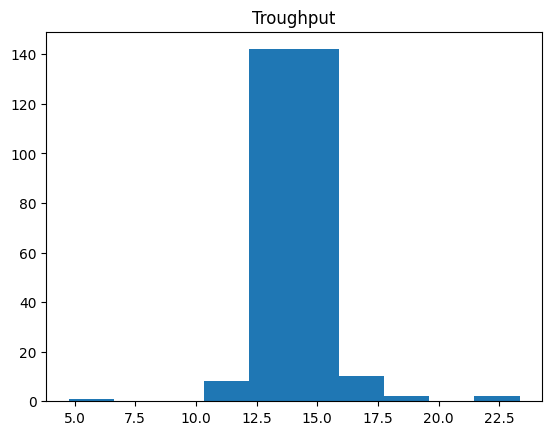

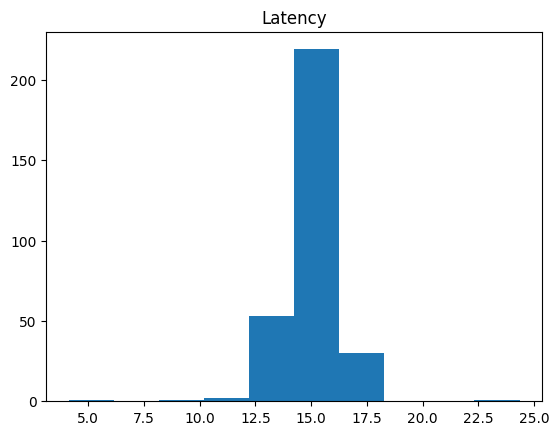

In [66]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
from scipy.io import loadmat  
from scipy.stats import norm
from sklearn.metrics import f1_score
 
data = loadmat('ex8data1.mat')  
X = data['X']  
Xval = data['Xval']
yval = data['yval'].ravel()
print(X.shape)
plt.figure()
plt.scatter(X[:, 0], X[:, 1], s=10, marker='o')
plt.xlabel('Troughput')
plt.ylabel('Latency')
plt.figure()
plt.hist(X[:, 0], bins=10, label='X1')
plt.title('Troughput')
plt.figure()
plt.hist(X[:, 1], bins=10, label='X2')
plt.title('Latency')

def estimate_gaussian(X):
    # średnie po kolumnach
    mu = np.mean(X, axis=0)
    # odchylenie standardowe (DDOF=0 – populacyjne)
    sigma = np.std(X, axis=0, ddof=0)
    return mu, sigma

# przykład użycia, zakładając, że masz załadowane dane X:
# X = ... (np. z pliku CSV lub innego źródła)
mu, sigma = estimate_gaussian(X)
print("mu:   ", mu)
print("sigma:", sigma)

pval = norm.pdf(Xval, loc=mu, scale=sigma).prod(axis=1)
print("Kształt pval:", pval.shape)
print("Przykładowe wartości pval:", pval[:5])



Shape Xval: (307, 2)
Liczba anomalii (yval==1): 9
True


C:\Users\Szymon\AppData\Local\Temp\ipykernel_13556\1517178937.py:9: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  diff=pval!=pdf_vals


Optymalny próg: 8.999852631901394e-05
Najlepsze F1: 0.875


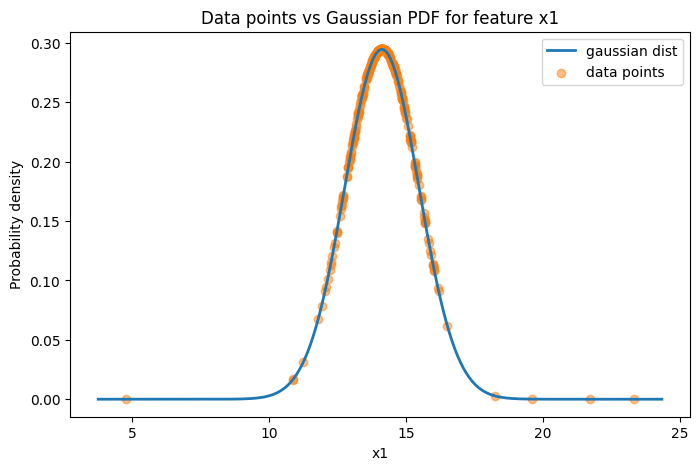

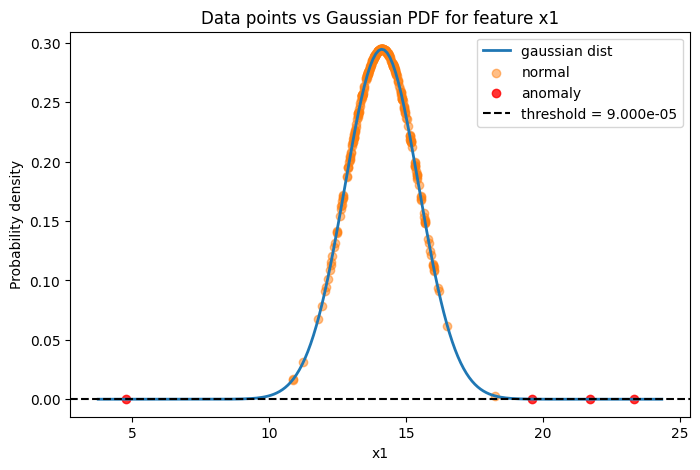

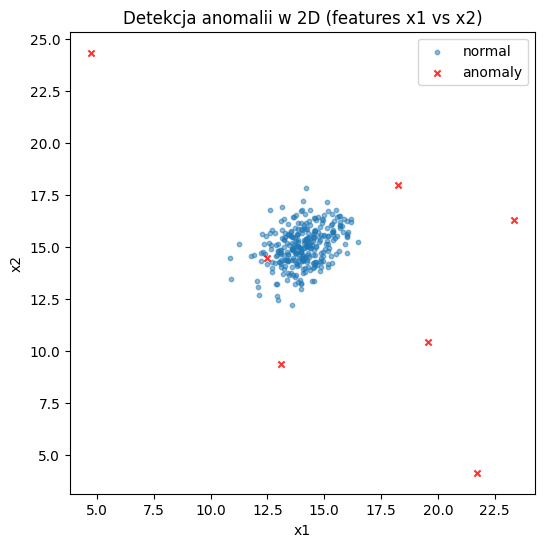

In [69]:
print("Shape Xval:", Xval.shape)
print("Liczba anomalii (yval==1):", np.sum(yval == 1))

x1 = X[:, 0]
p_x1 = norm.pdf(x1, loc=mu[0], scale=sigma[0])

x_vals = np.linspace(x1.min() - 1, x1.max() + 1, 200)
pdf_vals = norm.pdf(x_vals, loc=mu[0], scale=sigma[0])
diff=pval!=pdf_vals
print(diff)




def select_threshold(pval, yval, num_steps=1000):
    best_epsilon = 0
    best_f1 = 0

    # zakres progów
    epsilons = np.linspace(pval.min(), pval.max(), num_steps)
    
    for eps in epsilons:
        # detekcja anomalii: True jeśli pval < eps
        preds = (pval < eps).astype(int)
        # obliczamy F1
        f1 = f1_score(yval, preds)
        
        if f1 > best_f1:
            best_f1 = f1
            best_epsilon = eps

    return best_epsilon, best_f1
best_eps, best_f1 = select_threshold(pval, yval)
print("Optymalny próg:", best_eps)
print("Najlepsze F1:", best_f1)
x_line=np.linspace(0,25, 100)
y_line=np.linspace(best_eps, best_eps, 100)
plt.figure(figsize=(8,5))
plt.plot(x_vals, pdf_vals, color='C0', lw=2, label='gaussian dist')
plt.scatter(x1, p_x1, color='C1', alpha=0.5, label='data points')
#plt.plot(x_line,y_line, color='Red', lw=2, label='Threshold')

plt.title("Data points vs Gaussian PDF for feature x1")
plt.xlabel("x1")
plt.ylabel("Probability density")
plt.legend()
plt.show()

mask_anomaly = p_x1 < best_eps   # True dla anomalii
mask_normal  = ~mask_anomaly     # reszta

plt.figure(figsize=(8,5))

# krzywa gęstości
plt.plot(x_vals, pdf_vals, color='C0', lw=2, label='gaussian dist')

# punkty normalne
plt.scatter(x1[mask_normal], p_x1[mask_normal],
            color='C1', alpha=0.5, label='normal')

# punkty uznane za anomalię
plt.scatter(x1[mask_anomaly], p_x1[mask_anomaly],
            color='red', alpha=0.8, label='anomaly')

# pozioma linia progu
plt.axhline(best_eps, color='k', linestyle='--', label=f'threshold = {best_eps:.3e}')

plt.title("Data points vs Gaussian PDF for feature x1")
plt.xlabel("x1")
plt.ylabel("Probability density")
plt.legend()
plt.show()

mask_anomaly = pval <= best_eps
mask_normal  = ~mask_anomaly

plt.figure(figsize=(6,6))
# normalne punkty
plt.scatter(X[mask_normal, 0], X[mask_normal, 1],
            s=10, marker='o', label='normal', alpha=0.5)
# anomalie
plt.scatter(X[mask_anomaly, 0], X[mask_anomaly, 1],
            s=20, marker='x', color='red', label='anomaly', alpha=0.8)

plt.title("Detekcja anomalii w 2D (features x1 vs x2)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.show()
